# Import Packages

In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Dataset
Dataset used for this analysis is retrieved from [Monthly electricity data - long format (CSV)](https://storage.googleapis.com/emb-prod-bkt-publicdata/public-downloads/monthly_full_release_long_format.csv). This dataset is made available by Ember on its website.

# Data Understanding
## Import Data

In [2]:
# import data using pandas
df = pd.read_csv("Monthly_Electrcity_Data.csv")
df.head()

,Area,Country code,Date,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,Argentina,ARG,01/01/2018,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,0.0,Electricity demand,Demand,Demand,TWh,12.77,NaN,NaN
1,Argentina,ARG,01/01/2018,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,0.0,Electricity generation,Aggregate fuel,Clean,%,34.57,NaN,NaN
2,Argentina,ARG,01/01/2018,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,0.0,Electricity generation,Aggregate fuel,Fossil,%,65.44,NaN,NaN
3,Argentina,ARG,01/01/2018,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,0.0,Electricity generation,Aggregate fuel,Gas and Other Fossil,%,63.40,NaN,NaN
4,Argentina,ARG,01/01/2018,Country,South America,Latin America and Caribbean,0.0,0.0,1.0,0.0,0.0,Electricity generation,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",%,29.08,NaN,NaN


## Data Description
### General Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474193 entries, 0 to 474192
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Area                 474193 non-null  object 
 1   Country code         423015 non-null  object 
 2   Date                 474193 non-null  object 
 3   Area type            474193 non-null  object 
 4   Continent            423015 non-null  object 
 5   Ember region         423015 non-null  object 
 6   EU                   423015 non-null  float64
 7   OECD                 423015 non-null  float64
 8   G20                  423015 non-null  float64
 9   G7                   423015 non-null  float64
 10  ASEAN                423015 non-null  float64
 11  Category             474193 non-null  object 
 12  Subcategory          474193 non-null  object 
 13  Variable             474193 non-null  object 
 14  Unit                 474193 non-null  object 
 15  Value            

From above, we can see that the dataset comprises of **474193 row/observations** across the **18 columns/common features**.

Based on the Non-Null Count, there are **null data** for some of the columns.

## Pre-processing
### Getting the data for Malaysia only.

In [4]:
# convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# filter data for Malaysia data only
df_msia = df[(df['Area'] == 'Malaysia')].copy()

# drop unnesscary columns
df_msia.drop(columns=['Country code', 'Area type', 'Continent', 'Ember region', 'EU', 'OECD', 'G20', 'G7','ASEAN'], inplace=True)

# filter data 2025 out
df_msia = df_msia[df_msia['Date'].dt.year < 2025].copy()

# Display tail of the filtered data
df_msia.tail()

,Area,Date,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
251044,Malaysia,2024-01-12,Power sector emissions,Fuel,Gas,mtCO2,3.04,-0.22,-6.75
251045,Malaysia,2024-01-12,Power sector emissions,Fuel,Hydro,mtCO2,0.07,0.00,0.00
251046,Malaysia,2024-01-12,Power sector emissions,Fuel,Other Fossil,mtCO2,0.04,0.01,33.33
251047,Malaysia,2024-01-12,Power sector emissions,Fuel,Solar,mtCO2,0.01,0.00,0.00
251048,Malaysia,2024-01-12,Power sector emissions,Total,Total emissions,mtCO2,9.47,0.33,3.61


Now we are having data for Malaysia only. But further filter needs to apply to get detailed information

# Data analysis and intepretation
## Total Electricity Generation (TWh)

In [5]:
# Filter for Electricity Generation in TWh units only
df_msia_generation = df_msia[(df_msia['Category'].isin(['Electricity generation'])) & (df_msia['Subcategory'].isin(['Fuel'])) 
                        & (df_msia['Unit'].isin(['TWh']))]

# Group by 'Variable' and sum the 'Value'
df_msia_byVariable = df_msia_generation.groupby('Variable')['Value'].sum().sort_values(ascending=False)

print("Total Electricity Generation (TWh) by Fuel Type in Malaysia:")
df_msia_byVariable

Total Electricity Generation (TWh) by Fuel Type in Malaysia:


Variable
Coal            525.82
Gas             408.66
Hydro           207.08
Bioenergy        27.81
Solar             9.35
Other Fossil      5.60
Name: Value, dtype: float64

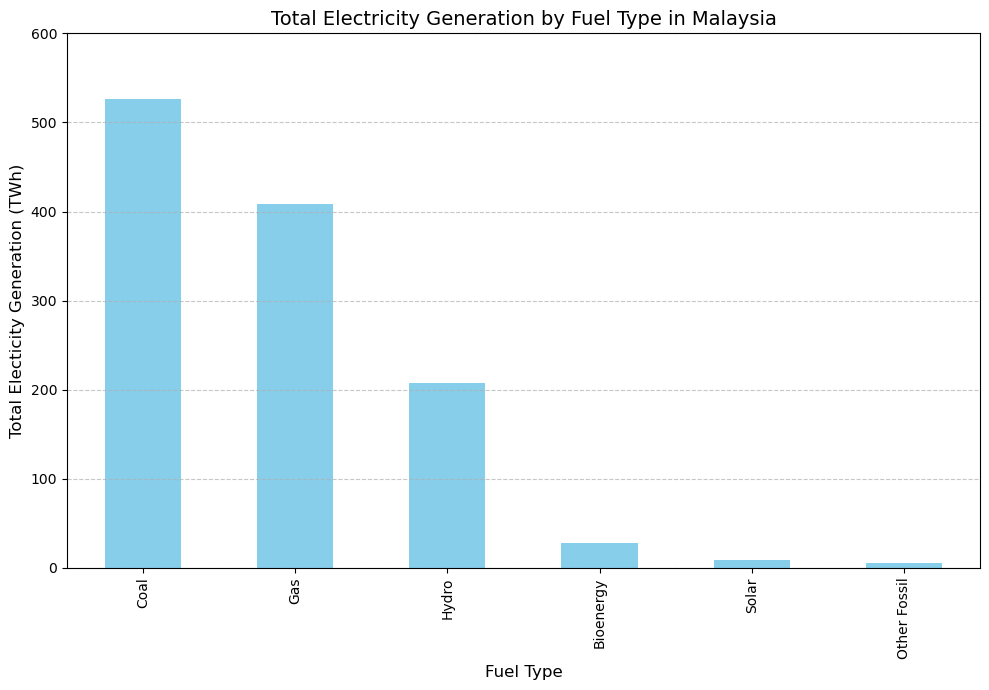

In [6]:
# The total electricity generation by fuel type
fig, ax = plt.subplots(figsize=(10, 7))
df_msia_byVariable.plot(kind='bar', color='skyblue')
ax.set_title('Total Electricity Generation by Fuel Type in Malaysia', fontsize=14)
ax.set_xlabel('Fuel Type', fontsize=12)
ax.set_ylabel('Total Electicity Generation (TWh)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0,600)
plt.tight_layout()
plt.show()

## Annual Electricity Generation (TWh)

In [7]:
# The total electricity generation by date and fuel type
df_msia_byDate = df_msia_generation.set_index('Date').copy()

df_msia_annual_byVariable = df_msia_byDate.pivot_table(
    index=df_msia_byDate.index,
    columns='Variable',
    values='Value',
    aggfunc='sum'
).fillna(0).resample('Y').sum() # Resample to annual sums for each fuel type

df_msia_annual_byVariable.index = df_msia_annual_byVariable.index.year

print("Total Yearly Electricity Generation (TWh) by Fuel Type in Malaysia:")
df_msia_annual_byVariable

Total Yearly Electricity Generation (TWh) by Fuel Type in Malaysia:


Variable,Bioenergy,Coal,Gas,Hydro,Other Fossil,Solar
Date,,,,,,
2018,3.11,70.50,61.15,25.98,0.52,0.03
2019,4.15,71.31,64.08,25.82,0.68,0.62
2020,3.40,80.43,46.99,27.28,0.53,0.85
2021,3.92,74.43,53.63,30.37,0.76,1.10
2022,4.31,72.58,59.65,32.11,1.48,1.63
2023,4.34,76.32,59.84,31.81,0.82,2.12
2024,4.58,80.25,63.32,33.71,0.81,3.00


In [8]:
# get the total annual electricity generation
annual_msia_gen = df_msia_generation.groupby(df_msia_generation['Date'].dt.year)['Value'].sum()
print("Total Yearly Electricity Generation (TWh) in Malaysia:")
annual_msia_gen


Total Yearly Electricity Generation (TWh) in Malaysia:


Date
2018    161.29
2019    166.66
2020    159.48
2021    164.21
2022    171.76
2023    175.25
2024    185.67
Name: Value, dtype: float64

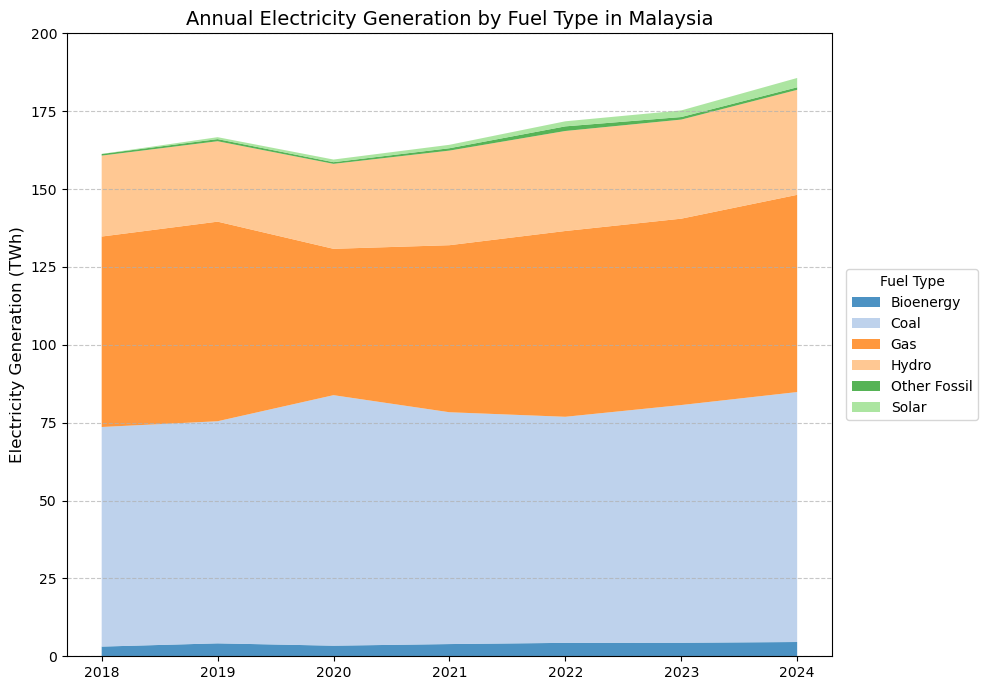

In [9]:
# Annual plots
fig, ax = plt.subplots(figsize=(10, 7))

fuel_types = df_msia_annual_byVariable.columns.tolist()
# Define colors for better visualization 
colors = plt.cm.tab20.colors[:len(fuel_types)]
ax.stackplot(df_msia_annual_byVariable.index,
             df_msia_annual_byVariable[fuel_types].values.T, # .values.T converts DataFrame columns into separate arrays for stacking
             labels=fuel_types,
             colors=colors,
             alpha=0.8) # Adjust transparency
ax.set_title('Annual Electricity Generation by Fuel Type in Malaysia', fontsize=14)
ax.set_ylabel('Electricity Generation (TWh)', fontsize=12)
ax.set_ylim(0,200)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), title='Fuel Type')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Key finding 1: Malaysia electricity source still dominated with non renewable energy 
- **Coal**: Stands out overwhelmingly as the largest contributor to Malaysia's electricity generation, with over 550 TWh. This highlights a strong reliance on coal as a primary energy source.

- **Gas**: Is the second-largest contributor, generating approximately 425 TWh. While significant, it's notably less than Coal.

- **Hydro**: Ranks as the third largest, contributing around 220 TWh. This indicates a consistent and substantial role for hydropower in the country's energy portfolio.

- **Bioenergy**: Is a much smaller contributor, falling below 50 TWh.

- **Solar**: Despite its impressive percentage growth rates seen in the previous heatmap, its total accumulated generation (around 10-20 TWh) remains very small when viewed in the context of the total electricity mix over these years. This visually confirms that while its growth is rapid, its absolute contribution is still minor.

- **Other Fossil**: Contributes the least, appearing almost negligible on this scale.

The vast majority of Malaysia's electricity generation during this period (2018-2024) came from fossil fuels (Coal and Gas).

Renewable sources like Solar and Bioenergy, despite their growth trends, cumulatively make up a very small fraction of the total electricity generated.

## Annual Electricity Demand

In [10]:
# Filter for Electricity Demand only
df_msia_demand = df_msia[(df_msia['Category'].isin(['Electricity demand']))]

# get the total annual electricity demand
annual_msia_dem = df_msia_demand.groupby(df_msia_demand['Date'].dt.year)['Value'].sum()
print("\nTotal Yearly Electricity Demand (TWh) in Malaysia:")
annual_msia_dem


Total Yearly Electricity Demand (TWh) in Malaysia:


Date
2018    161.35
2019    166.75
2020    159.44
2021    164.26
2022    171.76
2023    175.31
2024    185.65
Name: Value, dtype: float64

## Annual Electricity Import

In [11]:
# Filter for Electricity Import only
df_msia_import = df_msia[(df_msia['Category'].isin(['Electricity imports']))]

# get the total annual electricity demand
annual_msia_import = df_msia_import.groupby(df_msia_import['Date'].dt.year)['Value'].sum()
print("\nTotal Yearly Electricity Import (TWh) in Malaysia:")
annual_msia_import


Total Yearly Electricity Import (TWh) in Malaysia:


Date
2018    0.06
2019    0.09
2020   -0.04
2021    0.05
2022    0.00
2023    0.06
2024   -0.02
Name: Value, dtype: float64

## Annual Power Sector Emissions

In [12]:
# Filter for Power Sector Emissions
df_msia_emission = df_msia[(df_msia['Category'].isin(['Power sector emissions'])) & (df_msia['Subcategory'].isin(['Fuel']))]

# get the total annual electricity demand
annual_msia_emission = df_msia_emission.groupby(df_msia_emission['Date'].dt.year)['Value'].sum()
print("\nTotal Yearly Power Sector Emissions (mtCO2) in Malaysia:")
annual_msia_emission


Total Yearly Power Sector Emissions (mtCO2) in Malaysia:


Date
2018    106.40
2019    109.15
2020    105.38
2021    104.86
2022    107.94
2023    111.00
2024    116.95
Name: Value, dtype: float64

In [13]:
# The total electricity generation by date and fuel type
df_msia_emission_byDate = df_msia_emission.set_index('Date').copy()

df_msia_emission_annual_byVariable = df_msia_emission_byDate.pivot_table(
    index=df_msia_byDate.index,
    columns='Variable',
    values='Value',
    aggfunc='sum'
).fillna(0).resample('Y').sum() # Resample to annual sums for each fuel type

df_msia_emission_annual_byVariable.index = df_msia_emission_annual_byVariable.index.year

print("Total Yearly Power Sector Emissions (mtCO2) by Fuel Type in Malaysia:")
df_msia_emission_annual_byVariable

Total Yearly Power Sector Emissions (mtCO2) by Fuel Type in Malaysia:


Variable,Bioenergy,Coal,Gas,Hydro,Other Fossil,Solar
Date,,,,,,
2018,0.71,63.56,41.12,0.62,0.39,0.00
2019,0.95,64.00,43.08,0.60,0.52,0.00
2020,0.76,71.98,31.60,0.64,0.40,0.00
2021,0.91,66.61,36.05,0.73,0.56,0.00
2022,0.96,64.96,40.10,0.78,1.04,0.10
2023,1.00,68.30,40.22,0.76,0.60,0.12
2024,1.07,71.81,42.56,0.82,0.57,0.12


## Overall Trend of Electricity Supply and Demand

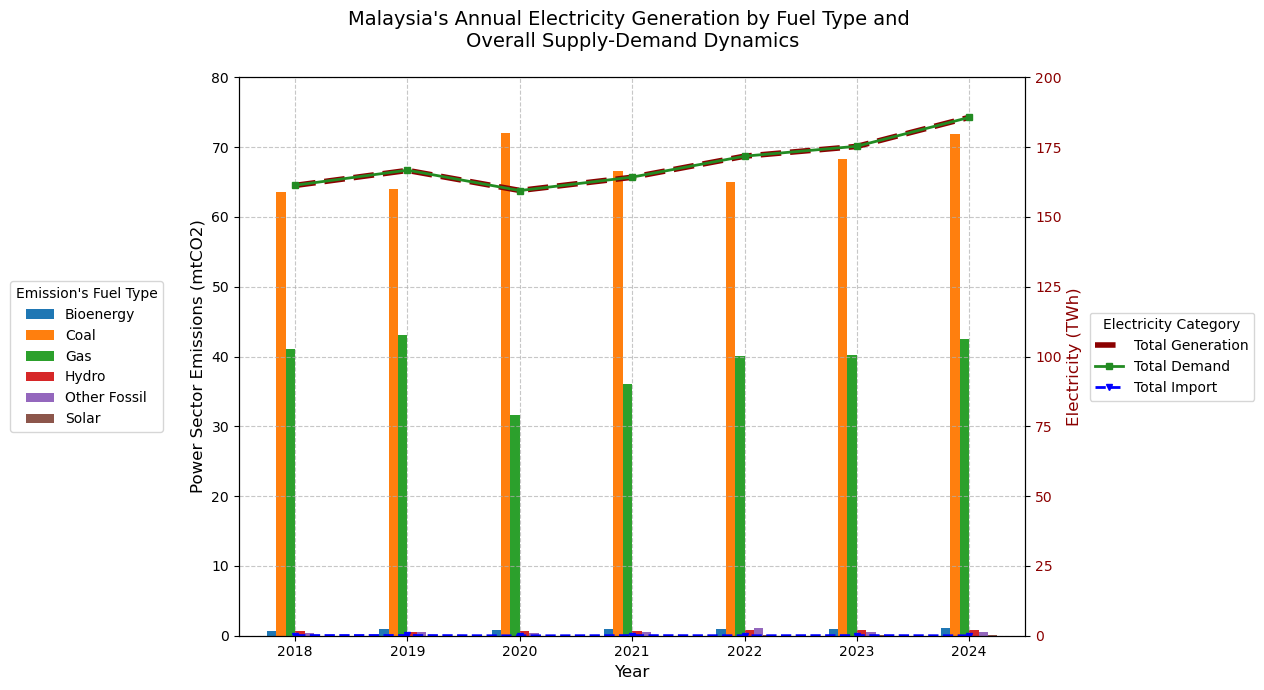

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 7))
df_msia_emission_annual_byVariable.plot(kind='bar', ax=plt.gca(), linewidth=2)
tick_labels = [str(year) for year in df_msia_annual_byVariable.index]
ax1.set_xticklabels(tick_labels, rotation=0) # Apply labels and rotate for readability
ax1.set_title('Malaysia\'s Annual Emissions by Fuel Type and \nOverall Supply-Demand Dynamics\n', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Power Sector Emissions (mtCO2)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0,80)
ax1.legend(loc='center left', bbox_to_anchor=(-0.3, 0.5), title='Emission\'s Fuel Type')

# Create a second Y-axis for the total demand line plot
ax2 = ax1.twinx()
x_line_positions = np.arange(len(annual_msia_gen.index))
ax2.plot(x_line_positions, annual_msia_gen, color='darkred', linestyle='--', markersize=4, linewidth=4, label='Total Generation')
ax2.plot(x_line_positions, annual_msia_dem, color='forestgreen', linestyle='-', marker='s', markersize=5, linewidth=2, label='Total Demand')
ax2.plot(x_line_positions, annual_msia_import, color='blue', linestyle='--', marker='v', markersize=4, linewidth=2, label='Total Import')
ax2.set_ylabel('Electricity (TWh)', color='darkred', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0,200)
ax2.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), title='Electricity Category')

plt.tight_layout()
plt.show()

- **Coal and gas** have been the **largest contributor to power sector emissions** in Malaysia. 

- **Bioenergy** shows very small emissions, likely from combustion processes.

- **Hydro** is considerable very low-carbon.

- **Solar** is zero-emission at the point of generation. 

The low and zero emission from hydro and solar confirms their environmental benefits relative to fossil fuels. Malaysia's power sector faces a monumental task in decarbonization, primarily due to the large emissions from coal and gas.

**Total Electricity Demand** closely mirrors the **Total Electricity Generation**. It indicates that electricity demand in Malaysia has been generally increasing from 2018 to 2024, keeping pace with generation.

**Total Electricity Import** generally sits at a very low level compared to total generation and demand, indicating that Malaysia is largely self-sufficient in electricity, with imports playing a minor supplementary role. 

## Annual changes of electricity generation

In [15]:
# changes in percentage
df_msia_annual_byVariable_perc = df_msia_annual_byVariable.pct_change() * 100
df_msia_annual_byVariable_perc

Variable,Bioenergy,Coal,Gas,Hydro,Other Fossil,Solar
Date,,,,,,
2018,NaN,NaN,NaN,NaN,NaN,NaN
2019,33.440514,1.148936,4.791496,-0.615858,30.769231,1966.666667
2020,-18.072289,12.789230,-26.669788,5.654531,-22.058824,37.096774
2021,15.294118,-7.459903,14.130666,11.326979,43.396226,29.411765
2022,9.948980,-2.485557,11.225061,5.729338,94.736842,48.181818
2023,0.696056,5.152935,0.318525,-0.934288,-44.594595,30.061350
2024,5.529954,5.149371,5.815508,5.972964,-1.219512,41.509434


In [16]:
# Calculate the difference from the previous year
annual_diff = df_msia_annual_byVariable.pct_change() * 100

# Remove NaN row 
annual_diff_final = annual_diff.dropna(how='all')

# Rename the columns
annual_diff_final.index.name = 'Year'
annual_diff_final.columns.name = 'Fuel Type'
annual_diff_final


Fuel Type,Bioenergy,Coal,Gas,Hydro,Other Fossil,Solar
Year,,,,,,
2019,33.440514,1.148936,4.791496,-0.615858,30.769231,1966.666667
2020,-18.072289,12.789230,-26.669788,5.654531,-22.058824,37.096774
2021,15.294118,-7.459903,14.130666,11.326979,43.396226,29.411765
2022,9.948980,-2.485557,11.225061,5.729338,94.736842,48.181818
2023,0.696056,5.152935,0.318525,-0.934288,-44.594595,30.061350
2024,5.529954,5.149371,5.815508,5.972964,-1.219512,41.509434


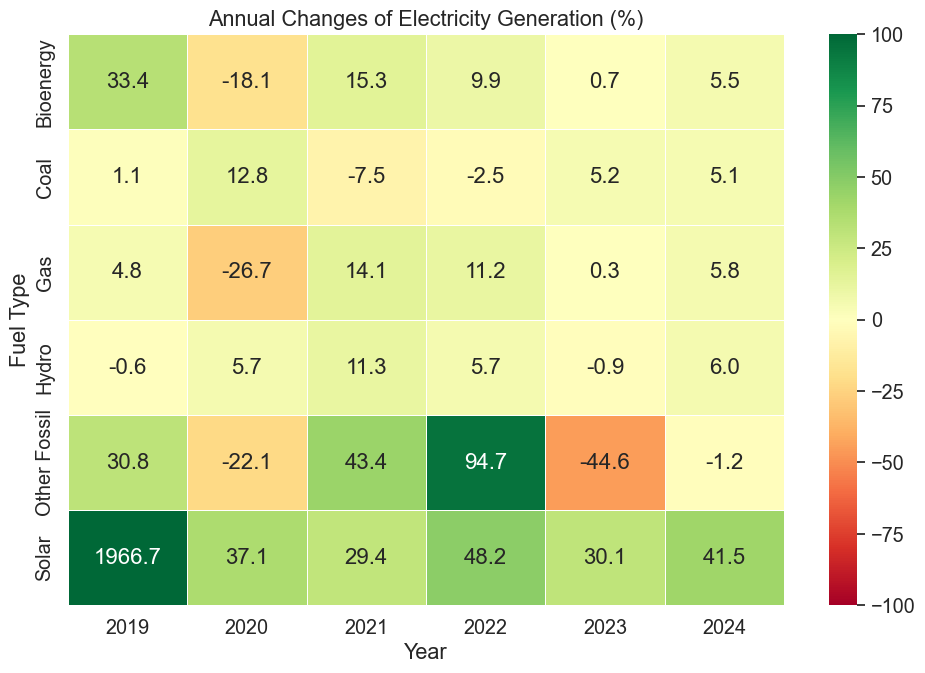

In [17]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.3)
sns.heatmap(annual_diff_final.transpose(), annot=True, cmap='RdYlGn', fmt=".1f", linewidths=.5, vmin=-100, vmax=100, 
                annot_kws={"fontsize":16})
plt.title('Annual Changes of Electricity Generation (%)')
plt.tight_layout()
plt.show()

### Key finding 2: Shifting electricity generation source
- **Solar** power shows incredibly high double-digit to triple-digit percentage growth rates every single year from 2019 to 2024. The 1966.7% growth in 2019 is particularly remarkable, highlighting its rapid expansion from a very low base.

- **Coal** generally shows more modest, fluctuating growth (e.g., +12.8% in 2020, +5.2% in 2023), with some slight declines (-7.5% in 2021). Its growth is far slower than Solar's.

- **Gas** experiences periods of growth and significant decline (e.g., -26.7% in 2020).

- **Bioenergy** generally shows positive growth, with a notable dip in 2020.

- **Hydro** remains relatively stable with smaller percentage changes, indicating a consistent contribution to the mix.

Despite consistently growing electricity demand from 2018 to 2024, the electricity generation from individual fuel types has shown varied trends, with some increasing while others fluctuate or decline. However, the overall total electricity generation has generally kept pace with demand, highlighting that **Malaysia still has significant room to add new clean capacity** and is actively diversifying its electricity generation landscape. 

The **exponential growth in solar electricity generation** across Malaysia over the last 6 years is particularly striking and signifies a clear shift in the country's energy investment and deployment priorities